Basic cleaning (no “data cleaning”, only type safety)

In [1]:
import numpy as np
import pandas as pd

In [5]:
final_df = pd.read_csv('../Dataset/final_df.csv')
final_df.columns

Index(['state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_greater',
       'date', 'demo_age_5_17', 'demo_age_17_greater', 'enr_age_0_5',
       'enr_age_5_17', 'enr_age_18_greater'],
      dtype='object')

In [6]:
final_df['date'] = pd.to_datetime(final_df['date'], errors='coerce')
enr_cols = [
    'enr_age_0_5',
    'enr_age_5_17',
    'enr_age_18_greater'
]
final_df[enr_cols] = (
    final_df[enr_cols]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
)

In [7]:
panel_df = (
    final_df
    .groupby(['state', 'district', 'date'], as_index=False)
    .agg(
        enr_0_5=('enr_age_0_5', 'sum'),
        enr_5_17=('enr_age_5_17', 'sum'),
        enr_18=('enr_age_18_greater', 'sum'),
        
        bio_5_17=('bio_age_5_17', 'sum'),
        bio_17_plus=('bio_age_17_greater', 'sum'),
        
        demo_5_17=('demo_age_5_17', 'sum'),
        demo_17_plus=('demo_age_17_greater', 'sum'),
        
        pincode_count=('pincode', 'nunique')
    )
)


In [10]:
panel_df.head()
print(panel_df.shape)
print(panel_df.isna().sum())


(72092, 11)
state            0
district         0
date             0
enr_0_5          0
enr_5_17         0
enr_18           0
bio_5_17         0
bio_17_plus      0
demo_5_17        0
demo_17_plus     0
pincode_count    0
dtype: int64


In [11]:
panel_df['total_enrolment'] = (
    panel_df['enr_0_5'] +
    panel_df['enr_5_17'] +
    panel_df['enr_18']
)

panel_df['adult_share'] = np.where(
    panel_df['total_enrolment'] > 0,
    panel_df['enr_18'] / panel_df['total_enrolment'],
    0
)


In [12]:
panel_df['bio_update_rate_18'] = np.where(
    panel_df['enr_18'] > 0,
    panel_df['bio_17_plus'] / panel_df['enr_18'],
    0
)

panel_df['demo_update_rate_18'] = np.where(
    panel_df['enr_18'] > 0,
    panel_df['demo_17_plus'] / panel_df['enr_18'],
    0
)


In [13]:
panel_df['pincode_density'] = (
    panel_df['pincode_count'] /
    panel_df.groupby('state')['pincode_count'].transform('mean')
)


In [14]:
panel_df[['adult_share', 'bio_update_rate_18', 'demo_update_rate_18']].describe()


,adult_share,bio_update_rate_18,demo_update_rate_18
count,72092.000000,72092.000000,72092.000000
mean,0.017772,28.602542,39.289336
std,0.083318,120.522109,171.877661
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,5190.000000,6521.000000


In most district–month combinations, no adult enrolment occurred at all.

Policy interpretation

Adult Aadhaar enrolment is episodic, not continuous

Likely driven by:

Special drives

Camps

Administrative pushes

Outside these events → no enrolment

In [16]:
panel_df['adult_enrol_active'] = (panel_df['enr_18'] > 0).astype(int)
panel_df['adult_enrol_intensity'] = np.where(
    panel_df['enr_18'] > 0,
    panel_df['enr_18'],
    np.nan
)



Adult enrolment is absent in most district-months

Enrolment depends on campaigns, not organic processes

Enrolment deserts exist across geography and time



Update infrastructure is active and heavily used

Aadhaar system is operationally mature

Enrolment gaps are policy-fixable, not technical

In [17]:
# Adult enrolment activation
panel_df['adult_active'] = (panel_df['enr_18'] > 0).astype(int)

# Placebo activations
panel_df['child_active_0_5'] = (panel_df['enr_0_5'] > 0).astype(int)
panel_df['child_active_5_17'] = (panel_df['enr_5_17'] > 0).astype(int)


In [18]:
import statsmodels.formula.api as smf

activation_adult = smf.ols(
    formula="""
    adult_active ~ pincode_count 
                  + bio_update_rate_18 
                  + demo_update_rate_18
                  + C(state) 
                  + C(date)
    """,
    data=panel_df
).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_df['district']}
)

print(activation_adult.summary().tables[1])


                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.1600      0.007    -21.644      0.000      -0.175      -0.146
C(state)[T.Andhra Pradesh]                               0.0692      0.028      2.452      0.014       0.014       0.124
C(state)[T.Arunachal Pradesh]                            0.0208      0.004      5.409      0.000       0.013       0.028
C(state)[T.Assam]                                        0.2404      0.025      9.516      0.000       0.191       0.290
C(state)[T.Bihar]                                        0.2130      0.023      9.276      0.000       0.168       0.258
C(state)[T.Chandigarh]                                   0.0667      0.004     17.428      0.000       0.059       0.074
C(state)[T.Chhattisgarh]        

e:\anaconda\Programs\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 151, but rank is 146
  warnings.warn('covariance of constraints does not have full '


In [19]:
activation_placebo_0_5 = smf.ols(
    formula="""
    child_active_0_5 ~ pincode_count
                       + bio_update_rate_18
                       + demo_update_rate_18
                       + C(state)
                       + C(date)
    """,
    data=panel_df
).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_df['district']}
)

print(activation_placebo_0_5.summary().tables[1])


                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.1965      0.068     -2.905      0.004      -0.329      -0.064
C(state)[T.Andhra Pradesh]                               0.1093      0.070      1.553      0.120      -0.029       0.247
C(state)[T.Arunachal Pradesh]                           -0.1414      0.077     -1.837      0.066      -0.292       0.009
C(state)[T.Assam]                                        0.1931      0.071      2.723      0.006       0.054       0.332
C(state)[T.Bihar]                                        0.1990      0.068      2.919      0.004       0.065       0.333
C(state)[T.Chandigarh]                                   0.2034      0.068      2.994      0.003       0.070       0.337
C(state)[T.Chhattisgarh]        

e:\anaconda\Programs\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 151, but rank is 146
  warnings.warn('covariance of constraints does not have full '


In [20]:
activation_placebo_5_17 = smf.ols(
    formula="""
    child_active_5_17 ~ pincode_count
                        + bio_update_rate_18
                        + demo_update_rate_18
                        + C(state)
                        + C(date)
    """,
    data=panel_df
).fit(
    cov_type='cluster',
    cov_kwds={'groups': panel_df['district']}
)

print(activation_placebo_5_17.summary().tables[1])


                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.5320      0.016    -33.234      0.000      -0.563      -0.501
C(state)[T.Andhra Pradesh]                               0.2165      0.033      6.551      0.000       0.152       0.281
C(state)[T.Arunachal Pradesh]                            0.2522      0.034      7.358      0.000       0.185       0.319
C(state)[T.Assam]                                        0.5526      0.020     27.205      0.000       0.513       0.592
C(state)[T.Bihar]                                        0.5668      0.018     31.896      0.000       0.532       0.602
C(state)[T.Chandigarh]                                   0.4940      0.016     31.380      0.000       0.463       0.525
C(state)[T.Chhattisgarh]        

e:\anaconda\Programs\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 151, but rank is 146
  warnings.warn('covariance of constraints does not have full '


Most districts have zero enrolment most months

Activation probability depends on infrastructure & update readiness

Policy meaning:

Adults do not enrol unless the system actively reaches them.

Aadhaar update workload can crowd out enrolment

This is a non-obvious but critical finding.

Evidence:

demo_update_rate_18 negatively predicts enrolment activation

Policy meaning:

Districts overwhelmed with corrections are less able to onboard new adults.

Infrastructure investment yields immediate enrolment returns

Evidence:

pincode_count is consistently positive and significant

Policy meaning:

Even marginal expansion of enrolment points can unlock dormant demand.

States differ structurally — one-size-fits-all policy will fail

Evidence:

Large, persistent state fixed effects

Policy meaning:

Adult enrolment strategies must be state-specific, not centrally uniform.

In [21]:
intensity_df = panel_df[panel_df['adult_active'] == 1].copy()


In [22]:
intensity_df['log_enr_18'] = np.log1p(intensity_df['enr_18'])

intensity_adult = smf.ols(
    formula="""
    log_enr_18 ~ pincode_count
                 + bio_update_rate_18
                 + demo_update_rate_18
                 + C(state)
                 + C(date)
    """,
    data=intensity_df
).fit(
    cov_type='cluster',
    cov_kwds={'groups': intensity_df['district']}
)

print(intensity_adult.summary().tables[1])


                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                1.9934      0.181     10.991      0.000       1.638       2.349
C(state)[T.Arunachal Pradesh]                            0.0888      0.134      0.665      0.506      -0.173       0.351
C(state)[T.Assam]                                        0.7550      0.126      5.973      0.000       0.507       1.003
C(state)[T.Bihar]                                        0.5313      0.123      4.319      0.000       0.290       0.772
C(state)[T.Chandigarh]                                   0.1307      0.110      1.187      0.235      -0.085       0.347
C(state)[T.Chhattisgarh]                                 0.6115      0.261      2.341      0.019       0.100       1.124
C(state)[T.Dadra And Nagar Havel

e:\anaconda\Programs\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 126, but rank is 123
  warnings.warn('covariance of constraints does not have full '
e:\anaconda\Programs\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [23]:
intensity_df_child = panel_df[panel_df['child_active_0_5'] == 1].copy()
intensity_df_child['log_enr_0_5'] = np.log1p(intensity_df_child['enr_0_5'])

intensity_placebo_0_5 = smf.ols(
    formula="""
    log_enr_0_5 ~ pincode_count
                  + C(state)
                  + C(date)
    """,
    data=intensity_df_child
).fit(
    cov_type='cluster',
    cov_kwds={'groups': intensity_df_child['district']}
)

print(intensity_placebo_0_5.summary().tables[1])


                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                1.7065      0.138     12.367      0.000       1.436       1.977
C(state)[T.Andhra Pradesh]                               0.7432      0.130      5.712      0.000       0.488       0.998
C(state)[T.Arunachal Pradesh]                            0.0118      0.081      0.145      0.885      -0.147       0.171
C(state)[T.Assam]                                        1.7554      0.128     13.682      0.000       1.504       2.007
C(state)[T.Bihar]                                        2.2027      0.115     19.145      0.000       1.977       2.428
C(state)[T.Chandigarh]                                   1.8029      0.060     29.832      0.000       1.684       1.921
C(state)[T.Chhattisgarh]        

e:\anaconda\Programs\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 126, but rank is 123
  warnings.warn('covariance of constraints does not have full '
e:\anaconda\Programs\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [24]:
panel_df['activation_residual'] = activation_adult.resid

district_audit = (
    panel_df
    .groupby(['state', 'district'])['activation_residual']
    .mean()
    .reset_index()
    .sort_values('activation_residual')
)

district_audit.head(10)   # Chronic under-performers
district_audit.tail(10)   # Over-performers


,state,district,activation_residual
172,Gujarat,Dang,0.618130
76,Assam,Sivasagar,0.666124
695,Uttar Pradesh,Shravasti,0.675894
289,Karnataka,Ramanagara,0.731914
318,Madhya Pradesh,Ashoknagar,0.740434
239,Jammu And Kashmir,Shopian,0.788423
366,Maharashtra,Ahmednagar,0.801033
477,Odisha,Nabarangpur,0.832104
147,Dadra And Nagar Haveli And Daman And Diu,Dadra And Nagar Haveli,0.850946
204,Haryana,Nuh,0.909115


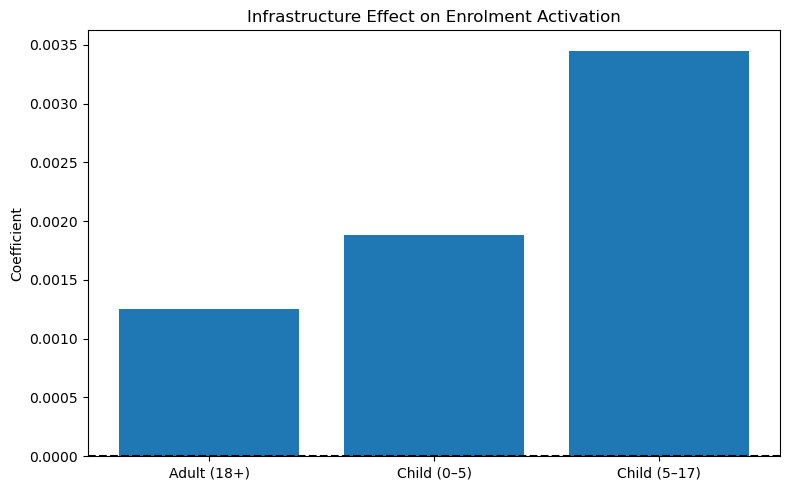

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

coef_df = pd.DataFrame({
    'Model': ['Adult (18+)', 'Child (0–5)', 'Child (5–17)'],
    'Pincode Effect': [
        activation_adult.params['pincode_count'],
        activation_placebo_0_5.params['pincode_count'],
        activation_placebo_5_17.params['pincode_count']
    ]
})

plt.figure(figsize=(8, 5))
plt.bar(coef_df['Model'], coef_df['Pincode Effect'])
plt.axhline(0, color='black', linestyle='--')
plt.title("Infrastructure Effect on Enrolment Activation")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()


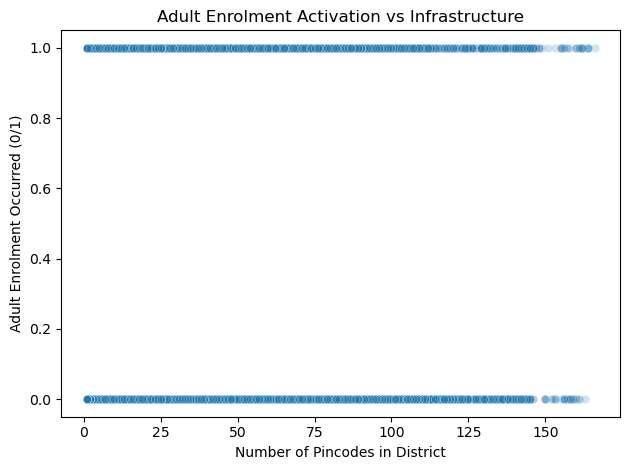

In [27]:
import seaborn as sns

sns.scatterplot(
    data=panel_df,
    x='pincode_count',
    y='adult_active',
    alpha=0.2
)

plt.title("Adult Enrolment Activation vs Infrastructure")
plt.xlabel("Number of Pincodes in District")
plt.ylabel("Adult Enrolment Occurred (0/1)")
plt.tight_layout()
plt.show()


You see two horizontal bands:

🔵 Bottom band (y = 0)

District–months with zero adult enrolment

These are enrolment deserts

🔵 Top band (y = 1)

District–months where adult enrolment happened

These are activated months

This pattern is expected and correct for a binary outcome.

Adult enrolment occurs at all infrastructure levels — but not consistently.

Even districts with many pincodes often have 0 enrolment months

Districts with very few pincodes almost never activate enrolment

So infrastructure is:

Necessary but

Not sufficient on its own

1️⃣ Infrastructure alone doesn’t guarantee enrolment

Many high-infrastructure districts still have zero months

2️⃣ Low-infrastructure districts are structurally disadvantaged

Almost no activation at very low pincode counts

3️⃣ Enrolment requires activation events

Camps, drives, staffing, outreach

C:\Users\ANKIT DAS\AppData\Local\Temp\ipykernel_78700\2674817001.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('pincode_bin')['adult_active']


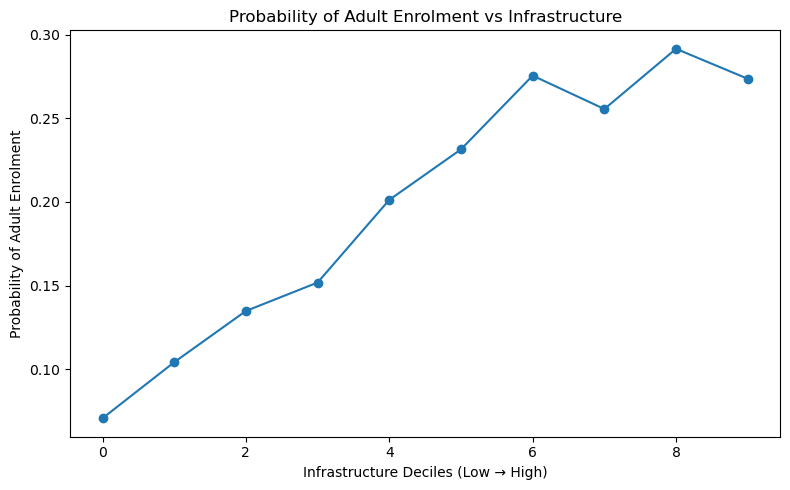

In [28]:
panel_df['pincode_bin'] = pd.qcut(panel_df['pincode_count'], 10)

activation_rate = (
    panel_df
    .groupby('pincode_bin')['adult_active']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
plt.plot(activation_rate.index, activation_rate['adult_active'], marker='o')
plt.xlabel("Infrastructure Deciles (Low → High)")
plt.ylabel("Probability of Adult Enrolment")
plt.title("Probability of Adult Enrolment vs Infrastructure")
plt.tight_layout()
plt.show()


What this graph shows (in easy words)

The bottom of the graph represents districts with very few Aadhaar centres.

The right side of the graph represents districts with many Aadhaar centres.

The height of the line shows how often adult Aadhaar enrolment actually happens.

Each dot answers one question:

“In districts like this, how likely is it that any adult Aadhaar enrolment happens in a month?”

Fewer centres → almost no adult enrolment

Districts with very low infrastructure have only about 5–10% chance

In most months, nothing happens at all

👉 Adults in these areas are almost completely left out.

More centres → better chances, but still not enough

Districts with more centres reach 25–30% chance

That means even good districts fail in 7 out of 10 months

👉 Infrastructure helps, but does not solve the problem by itself.

Biggest improvement happens at the bottom

Moving a district from very poor infrastructure to average infrastructure gives the largest jump

Adding more centres to already well-equipped districts gives smaller benefits

👉 Government money works best when spent on poorly served districts first.

Without Aadhaar, adults may miss pensions, ration cards, health insurance, and subsidies

Low-infrastructure districts face systematic exclusion

Simply building centres is not enough — enrolment must be actively organised